# Relations from occurrences in the same sentences

In [3]:
import pickle
import re
# print the named entities frist 10
def load_nes(type):
    
    with open('./data/named_entities.pickle', 'rb') as f:
        i = 0

        nes_raw = [];
        while True:
            try:
                ne = pickle.load(f)
                # print all the GPE entities, GPE: Geopolitical Entity
                if ne.label() == type :nes_raw.append(str(ne))

            except EOFError:
                break
    return process_nes(nes_raw,type)

def process_nes(nes,type):
    transformed_nes = []
    i=0
    for ne in nes:
        loc = ne.replace('('+type+' ','')
        loc = re.sub(r'/[A-Z]+','',loc)
        loc = loc.replace(')','')
        if i<10: print(loc)
        i+=1
        transformed_nes.append(loc)

    return transformed_nes

In [8]:
def read_file(file_name):
    with open(file_name) as f:
        lines = f.readlines()
    return lines

path = './data/book_text'

text = read_file(path)

# remove all the \n in the text
text = [x.strip() for x in text]
text = ' '.join(text)

import nltk
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
sentences = tokenizer.tokenize(text)

text[:100]

'PART ONE     CHAPTER I A SHIFTING REEF   The year 1866 was signalised by a remarkable incident, a my'

In [21]:
locations = load_nes('LOCATION')
persons = load_nes('PERSON')

West India
North Pacific Ocean
North Sea
North Pacific Ocean
East River
North
Northern Pacific
France
North Sea
Southern Seas
_Governor Higginson_
Burnach Steam Navigation Company
Baker
Pacific Steam Navigation Company
_Helvetia_
_Pereire_
Dick
Pliny
Bishop Pontoppidan
Paul Heggede


In [26]:
# sort entities by document frequency
from collections import Counter
def sort_by_df(entities):
    c = Counter(entities)
    return c.most_common()

locations_sorted = sort_by_df(locations)
persons_sorted = sort_by_df(persons)

# print the top 10 entities
for i in range(10):    print(locations_sorted[i])
print('----------------')
for i in range(10):    print(persons_sorted[i])

('South Pole', 11)
('Mediterranean', 6)
('North Atlantic', 4)
('Ocean', 4)
('North Pacific', 3)
('Persian Gulf', 3)
('deg.', 3)
('North Pacific Ocean', 2)
('North Sea', 2)
('Black River', 2)
----------------
('Captain Nemo', 244)
('Conseil', 184)
('Ned Land', 143)
('Ned', 119)
('Nemo', 67)
('Sir', 16)
('Master Land', 14)
('La Perouse', 10)
('Master', 9)
('Urville', 9)


In [52]:
# count the number of matches for each PERSON entity and LOCATION entity
def count_matches(entities, sentences):
    # count the number of sentences that containing all the entities
    count = 0
    for sentence in sentences:
        match = True
        for entity in entities:
            if entity not in sentence:
                match = False
                break
        if match: count += 1
    return count


def sentence_match(sentences, entities_class1, entities_class2):
    # set of all the person-location combinations
    person_location_pairs = [[person, location] for person in entities_class1 for location in entities_class2]

    # remove duplicate pairs
    person_location_pairs = list(set(tuple(sorted(l)) for l in person_location_pairs))

    # count the number of matches for each person-location pair
    person_location_pairs_count = []
    for pair in person_location_pairs:
        count = count_matches(pair, sentences)
        person_location_pairs_count.append([pair[0], pair[1], count])

    # sort the pairs by the number of matches
    person_location_pairs_count = sorted(person_location_pairs_count, key=lambda x: x[2], reverse=True)
    return person_location_pairs_count

person_location_pairs_count = sentence_match(sentences, persons, locations)
# print the top 10 pairs
for i in range(10):    print(person_location_pairs_count[i])


['Captain', 'South', 7]
['Captain', 'South Pole', 6]
['Nemo', 'South Pole', 4]
['Ocean', '_Nautilus_', 4]
['Nemo', 'South', 4]
['Captain Nemo', 'South Pole', 4]
['Captain Nemo', 'South', 4]
['Europe', 'Ocean', 4]
['Captain', 'Ocean', 3]
['Captain', 'North', 3]


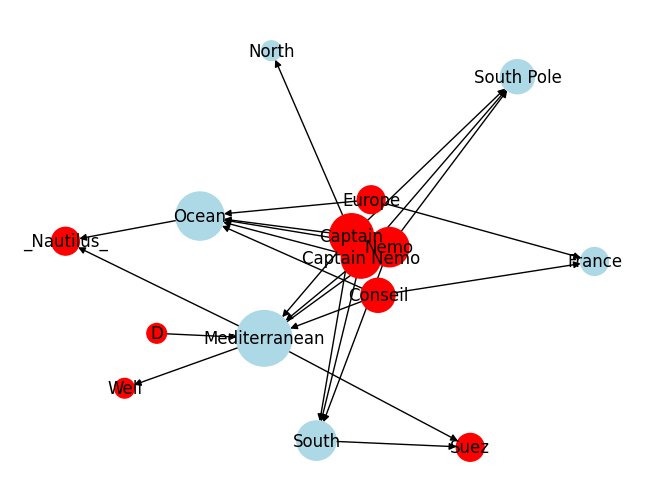

In [104]:
# display the graph
import networkx as nx                                                             
import matplotlib.pyplot as plt                                                   
import numpy as np
# plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')

G = nx.DiGraph()                                                                  
                                                                                
# add the edges to the graph
for pair in person_location_pairs_count:
    if pair[2] > 1:   
        G.add_edge(pair[0], pair[1], weight=pair[2])

pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))    

# dictionary of node degrees
d = dict(nx.degree(G))
# colors based on node type, PERSON: red, LOCATION: blue
colors = ['red' if node in persons else 'lightblue' for node in G.nodes()]


nx.draw(G, pos, node_color=colors, 
        with_labels=True, 
        nodelist=list(d.keys()), 
        node_size=[d[k]*200 for k in d])                                                                        
plt.show()

# save the graph
nx.write_gexf(G, "./plots/graph.gexf")


In [43]:
# extract nautical coordinates
import pandas as pd
df_coo  = pd.read_csv('./data/coordinates.csv')
df_coo.head()

coos_tokens = []
for coo in df_coo['index']:   coos_tokens.append(text[coo-15:coo])

coos_tokens[:10]

person_location_pairs_count = sentence_match(sentences, persons, coos_tokens)
# print the top 10 pairs
for i in range(10):    print(person_location_pairs_count[i])

['Cape Wessel', 'ituation in 135', 1]
['Captain', 'hat name in 122', 1]
['Dillon', 'land situated 8', 1]
['Captain', 'here, and in 32', 1]
['Vasco', 'ated between 10', 1]
['Captain', 'situation at 51', 1]
['Vasco', 'ween 10° and 14', 1]
['Nemo', 'hat name in 122', 1]
[' evening, in 21', 'Arabia', 1]
['D', 'land situated 8', 1]


# Coreference resolution

In [1]:
                                            
# alternative: coreferee, https://github.com/richardpaulhudson/coreferee
# import coreferee
# nlp = spacy.load("en_core_web_sm")                                             
# nlp.add_pipe("coreferee", config={"resolve_anafora": True})                    
                                                                            
# doc = nlp("John went to the store. He bought some milk.")                      
# print(doc._.coref_chains) 




In [4]:
import spacy
# ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
# en-core-web-lg 2.3.1 requires spacy<2.4.0,>=2.3.0, but you have spacy 3.5.3 which is incompatible.
# mordecai 2.1.0 requires spacy<3.0,>=2.3, but you have spacy 3.5.3 which is incompatible
nlp = spacy.load("en_core_web_sm")
doc = nlp('Barack Obama was born in Hawaii.  He was elected president in 2008.')
for token in doc:
    print(token.text,  token.pos_,  token.dep_)

# solve co-reference resolution by assigning the nearest noun as the subject

    

Barack PROPN compound
Obama PROPN nsubjpass
was AUX auxpass
born VERB ROOT
in ADP prep
Hawaii PROPN pobj
. PUNCT punct
  SPACE dep
He PRON nsubjpass
was AUX auxpass
elected VERB ROOT
president NOUN oprd
in ADP prep
2008 NUM pobj
. PUNCT punct


In [8]:
from rdflib import Graph                                                       
                                                                        
# Create a new graph                                                           
g = Graph()                                                                    
                                                                        
# Load the data from a file                                                    
g.parse("./data/book_text", format="nt")                                     
                                                                        
# Print the graph                                                              
# print(g.serialize(format="turtle").decode("utf-8"))

ParserError: Invalid line: PART ONE